In [1]:
import requests
import re
import sys
import os
import gc

import time
from PIL import Image
import io
import pandas as pd
import numpy as np
import faiss
import torch
import torch.nn as nn
from tqdm import tqdm

import plotly.express as px

In [3]:
amazon_data = pd.read_csv('../../RecommenderSystems/amazonRatingsData/ratings.csv')

In [4]:
amazon_data.head(2)

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [5]:
amazon_data = amazon_data.rename(columns={'AKM1MP6P0OYPR': 'userId', '0132793040': 'productId', '5.0':'rating', '1365811200':'timestamp'})

In [6]:
amazon_data.head(2)

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600


In [7]:
len(amazon_data)

7824481

In [8]:
avg_rating_df = pd.DataFrame(amazon_data.groupby('userId', as_index=False).agg({'productId':'count', 'rating':'mean'})).rename(columns={'productId':'count', 'rating':'avgRating'}).sort_values(by='count',ascending=False).reset_index(drop=True)
avg_rating_df.head(2)                          

,userId,count,avgRating
0,A5JLAU2ARJ0BO,520,3.861538
1,ADLVFFE4VBT8,501,4.283433


In [9]:
user_list_giving_most_ratings = avg_rating_df.loc[:999, 'userId'].tolist()
len(user_list_giving_most_ratings)

1000

In [10]:
amazon_data_with_users_giving_most_rating = amazon_data[amazon_data['userId'].isin(user_list_giving_most_ratings)]


In [11]:
products_getting_most_rating = pd.DataFrame(amazon_data_with_users_giving_most_rating.groupby('productId', as_index=False).agg({'userId':'count'})).rename(columns={'userId':'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
products_getting_most_rating.head(2)

,productId,count
0,B0088CJT4U,168
1,B003ES5ZUU,144


In [12]:
product_list_getting_most_rating = products_getting_most_rating.loc[:999,'productId'].tolist()
len(product_list_getting_most_rating)

1000

In [13]:
amazon_data_sampled = amazon_data[(amazon_data['userId'].isin(user_list_giving_most_ratings)) & (amazon_data['productId'].isin(product_list_getting_most_rating))]
amazon_data_sampled.head(2)

,userId,productId,rating,timestamp
40053,A3EZEP0FX5BC1P,B00004SB92,5.0,1338422400
40075,ATDE9JYCPI0L1,B00004SB92,5.0,1235692800


In [14]:
len(amazon_data_sampled)

22246

In [15]:
avg_dict = {}

for i in range(1000):
    uid = avg_rating_df.loc[i, 'userId']
    rate = avg_rating_df.loc[i, 'avgRating']

    avg_dict[uid] = rate

In [16]:
merge_df = pd.merge(pd.DataFrame(user_list_giving_most_ratings, columns=['userId']), pd.DataFrame(product_list_getting_most_rating, columns=['productId']), how='cross')
merge_df['mean'] = merge_df['userId'].apply(lambda x: avg_dict[x])

In [17]:
amazon_data_merged = merge_df.merge(amazon_data_sampled, on=['userId','productId'], how='left')
amazon_data_merged['rating'] = amazon_data_merged['rating'].where(amazon_data_merged['rating'] > -1, amazon_data_merged['mean'])

In [18]:
amazon_data_table = amazon_data_merged.pivot(index='userId', columns='productId', values=['rating'])
amazon_data_table.head(3)

rating                                              \
productId      B00004SB92 B00004T8R2 B00004WCIC B00004ZCJE B00005LEN4   
userId                                                                  
A100UD67AHFODS   4.508621   4.508621   4.508621   4.508621   4.508621   
A100WO06OQR8BQ   3.651515   3.651515   3.651515   3.651515   3.651515   
A105S56ODHGJEK   3.838235   3.838235   3.838235   3.838235   3.838235   

                                                                       ...  \
productId      B00005T3G0 B000067RT6 B00006B7DA B00006I53S B00006JN3G  ...   
userId                                                                 ...   
A100UD67AHFODS   4.508621   4.508621   4.508621   4.508621   4.508621  ...   
A100WO06OQR8BQ   3.651515   3.651515   3.651515   3.651515   3.651515  ...   
A105S56ODHGJEK   3.838235   3.838235   3.838235   3.838235   3.838235  ...   

                                                                       \
productId      B00JEVHZHC B00JF0D7RE B00JKM0EQE B00JP12170 B00JWV1LP6   
userId                                                                  
A100UD67AHFODS   4.508621   4.508621   4.508621   4.508621   4.508621   
A100WO06OQR8BQ   3.651515   3.651515   3.651515   3.651515   3.651515   
A105S56ODHGJEK   3.838235   3.838235   3.838235   3.838235   3.838235   

                                                                       
productId      B00K91DB7Y B00KJJW36G B00L21HC7A B00L26YDA4 B00L3YHF6O  
userId                                                                 
A100UD67AHFODS   4.508621   4.508621   4.508621   4.508621   4.508621  
A100WO06OQR8BQ   1.000000   3.651515   3.651515   3.651515   3.651515  
A105S56ODHGJEK   3.838235   3.838235   3.838235   3.838235   3.838235  

[3 rows x 1000 columns]

In [19]:
index_amazon_data = amazon_data_table.reset_index()
index_amazon_data.head(2)

userId     rating                                   \
productId                 B00004SB92 B00004T8R2 B00004WCIC B00004ZCJE   
0          A100UD67AHFODS   4.508621   4.508621   4.508621   4.508621   
1          A100WO06OQR8BQ   3.651515   3.651515   3.651515   3.651515   

                                                                  ...  \
productId B00005LEN4 B00005T3G0 B000067RT6 B00006B7DA B00006I53S  ...   
0           4.508621   4.508621   4.508621   4.508621   4.508621  ...   
1           3.651515   3.651515   3.651515   3.651515   3.651515  ...   

                                                                             \
productId B00JEVHZHC B00JF0D7RE B00JKM0EQE B00JP12170 B00JWV1LP6 B00K91DB7Y   
0           4.508621   4.508621   4.508621   4.508621   4.508621   4.508621   
1           3.651515   3.651515   3.651515   3.651515   3.651515   1.000000   

                                                       
productId B00KJJW36G B00L21HC7A B00L26YDA4 B00L3YHF6O  
0           4.508621   4.508621   4.508621   4.508621  
1           3.651515   3.651515   3.651515   3.651515  

[2 rows x 1001 columns]

In [20]:
rating_matrix = amazon_data_table.values
u, sigma, vt = np.linalg.svd(rating_matrix)
importances = sigma / np.sum(sigma)
print('first 10 singular value percentage\n', importances[:10])

# for visualization
reduced_dim = 2

reduced_u = np.mat(u[:, :reduced_dim])
reduced_sigma = np.eye(reduced_dim) * sigma[:reduced_dim]
reduced_vt = np.mat(vt[:reduced_dim, :])

print('reduced_u shape :', reduced_u.shape)
print('reduced_vt shape :', reduced_vt.shape)

first 10 singular value percentage
 [0.57762694 0.00204558 0.00183212 0.00173306 0.00172551 0.00162342
 0.00159142 0.00158615 0.00154115 0.00152979]
reduced_u shape : (1000, 2)
reduced_vt shape : (2, 1000)


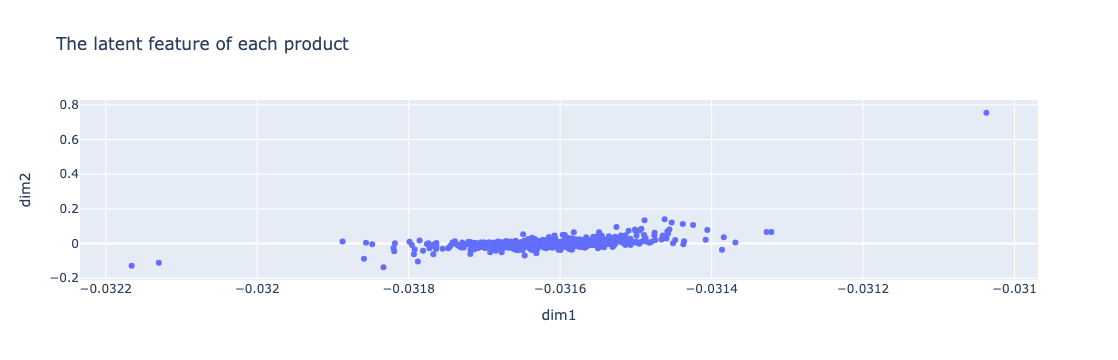

In [22]:
items_list = [item[1] for item in amazon_data_table.columns.tolist()]

v = reduced_vt.T
data = np.hstack([v, np.array(items_list).reshape(-1, 1)])
vis_df = pd.DataFrame(data, columns=['dim1', 'dim2', 'productId'])
vis_df['dim1'] = vis_df['dim1'].astype(np.float64)
vis_df['dim2'] = vis_df['dim2'].astype(np.float64)

fig = px.scatter(vis_df, x='dim1', y='dim2', hover_data=['productId'], 
                 title='The latent feature of each product')
fig.show()

In [21]:
'We can also use correlation coefficient to create correlation matrix from SVD and use that to get recommendations'

'We can also use correlation coefficient to create correlation matrix from SVD and use that to get recommendations'

In [22]:
amazon_table_transpose = amazon_data_table.T

In [23]:
amazon_table_transpose.head(2)

userId             A100UD67AHFODS  A100WO06OQR8BQ  A105S56ODHGJEK  \
       productId                                                    
rating B00004SB92        4.508621        3.651515        3.838235   
       B00004T8R2        4.508621        3.651515        3.838235   

userId             A105TOJ6LTVMBG  A10AFVU66A79Y1  A10NMELR4KX0J6  \
       productId                                                    
rating B00004SB92         3.84507        4.184615           4.125   
       B00004T8R2         3.84507        4.184615           4.125   

userId             A10O7THJ2O20AG  A10PEXB6XAQ5XF  A10X9ME6R66JDX  \
       productId                                                    
rating B00004SB92           4.975        4.028037        4.661972   
       B00004T8R2           4.975        4.028037        4.661972   

userId             A10Y058K7B96C6  ...  AYLLSFYS3UP1H  AYMD77ITD15PT  \
       productId                   ...                                 
rating B00004SB92        4.422764  ...       4.354839       4.244444   
       B00004T8R2        4.422764  ...       4.354839       4.244444   

userId             AYNAH993VDECT  AYO1146CBIV5C  AYOMAHLWRQHUG  AYOTEJ617O60K  \
       productId                                                                
rating B00004SB92       4.320988       4.433333        4.28125       3.888889   
       B00004T8R2       4.320988       4.433333        4.28125       3.888889   

userId             AZ515FFZ7I2P7  AZAC8O310IK4E  AZCE11PSTCH1L  AZMY6E8B52L2T  
       productId                                                               
rating B00004SB92       4.270833       4.320388            4.4       4.714286  
       B00004T8R2       4.270833       4.320388            4.4       4.714286  

[2 rows x 1000 columns]

In [24]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(amazon_table_transpose)
decomposed_matrix.shape

(1000, 10)

In [25]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1000, 1000)

In [26]:
amazon_table_transpose.index[999]

('rating', 'B00L3YHF6O')

In [27]:
correlation_product_ID = correlation_matrix[999]
correlation_product_ID.shape

(1000,)

In [29]:
Recommendations = list(amazon_table_transpose.index[correlation_product_ID > 0.65])


In [30]:
Recommendations[0:25]

[('rating', 'B00004SB92'),
 ('rating', 'B00004T8R2'),
 ('rating', 'B00004WCIC'),
 ('rating', 'B00004ZCJE'),
 ('rating', 'B00005LEN4'),
 ('rating', 'B00005T3G0'),
 ('rating', 'B000067RT6'),
 ('rating', 'B00006B7DA'),
 ('rating', 'B00006I53S'),
 ('rating', 'B00006JN3G'),
 ('rating', 'B00006RVPW'),
 ('rating', 'B00007E7JU'),
 ('rating', 'B00007EDZG'),
 ('rating', 'B00007GQLU'),
 ('rating', 'B00007IFED'),
 ('rating', 'B00007KDVI'),
 ('rating', 'B00007M1TZ'),
 ('rating', 'B000089GN3'),
 ('rating', 'B00009R6TA'),
 ('rating', 'B00009XVCZ'),
 ('rating', 'B0000BVYTV'),
 ('rating', 'B0000BZL1P'),
 ('rating', 'B00017LSPI'),
 ('rating', 'B0001FTVEK'),
 ('rating', 'B0001Y7UAI')]